# How to extract the minimum pressure line as a function of height
This example shows how to use extracted slices at regular Z-positions to create a line that represents the minimum pressure as a function of height. This analysis is important because "some quote from CPFD on this case"

## Problem setup
The dataset in question is a simulation of a cyclone from Barracuda Virtual Reactor by CPFD. To illustrate the process we'll use, we first load the data and show slices at regular Z-intervals.  For each slice we want determine the XYZ location of the minimum pressure and create a new I-Ordered line to hold the results.

In the image below we're only showing a few slices for illustration purposes.  Later in the script we'll extract many more slices to achieve a more accurate result.

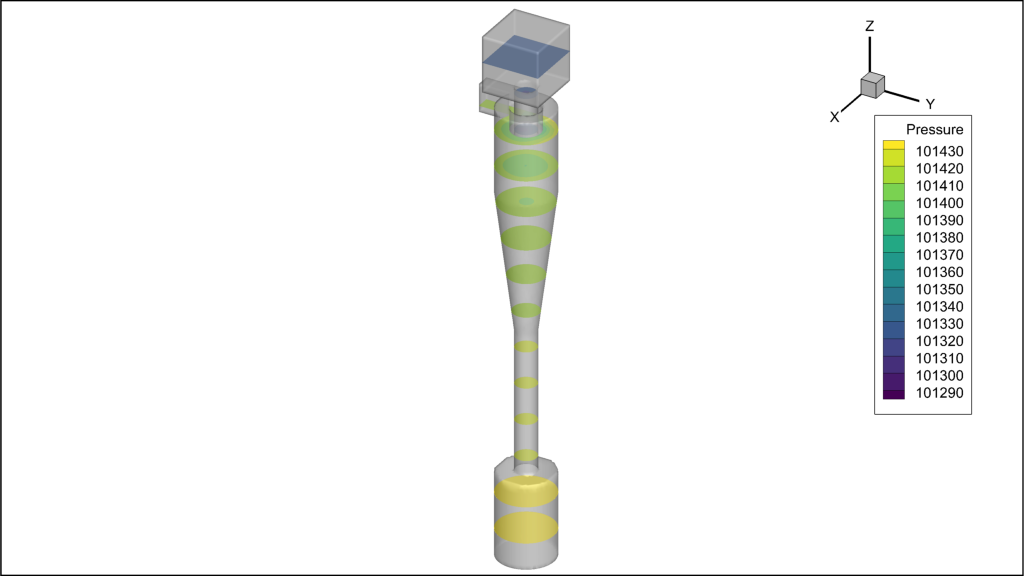

In [1]:
import numpy as np
import tecplot as tp
from tecplot.constant import *
tp.new_layout()
ds = tp.data.load_tecplot("cyclone_one_step.plt")
tp.active_frame().plot().fieldmaps().surfaces.surfaces_to_plot = SurfacesToPlot.BoundaryFaces
plot = tp.active_frame().plot(PlotType.Cartesian3D)
plot.use_translucency=True
plot.slice(0).orientation=SliceSurface.ZPlanes
plot.slice(0).show_primary_slice=False
plot.slice(0).show_start_and_end_slices=True
plot.slice(0).show_intermediate_slices=True
plot.slice(0).num_intermediate_slices=12
tp.active_frame().plot().contour(0).variable=ds.variable("Pressure")
plot.show_slices=True
tp.extension.ipython.show(width=1024)

## Slice extraction to find minimum Pressure
Here we'll demonstrate how to extract a slice. It's important to note that in this problem we want to maintain the cell-centered nature of the Pressure variable when extracting the slice. To do this we use tp.data.extract.extract_slice() and the 'copy_cell_centers' parameter.

Once the slice is extracted we find the cell number that contains the minimum Pressure value

In [2]:
zmin,zmax = ds.zone(0).values("z").minmax()
zmid = (zmax+zmin)/2
slice = tp.data.extract.extract_slice(origin=(0,0,zmid), normal=(0,0,1), copy_cell_centers=True)

vals = slice.values("Pressure")
# Prove that we have cell-centered Pressure values
print(vals.location)

print(f"Min Pressure: {vals.min()}")
cell_location = np.argmin(vals[:])
print(f"Cell number: {cell_location}")
print(f"Pressure at cell {cell_location}: {vals[cell_location]}")

ValueLocation.CellCentered
Min Pressure: 101418.3671875
Cell number: 383
Pressure at cell 383: 101418.3671875


## Getting the cell-centered XYZ values
Now that we have the cell location of the minimum pressure we need to obtain the XYZ values for that cell.  XYZ values are stored at the nodes though, so we'll compute cell-centered copies of the XYZ variables.

In [3]:
# Compute cell-centered equivalents of the XYZ variables. We limit this computation to the slice for efficiency
tp.data.operate.execute_equation("""
  {X_cc} = {X}
  {Y_cc} = {Y}
  {Z_cc} = {Z}""", value_location=ValueLocation.CellCentered, zones=[slice])
x = slice.values("X_cc")[cell_location]
y = slice.values("Y_cc")[cell_location]
z = slice.values("Z_cc")[cell_location]
print("XYZ location of minimum Pressure: ", (x,y,z))

#Confirm it by probing at that position
res = tp.data.query.probe_on_surface(positions=(x,y,z), zones=[slice])
print("Pressure value: ", res.data[ds.variable("Pressure").index])

XYZ location of minimum Pressure:  (-0.04773988574743271, -0.02212708257138729, 0.9375)
Pressure value:  101418.3671875


## Putting it all together
Now that we know the technique to determine the XYZ location of the minimum Pressure value, we'll do it for a list of Z-locations and then create an I-Ordered (linear) zone with the result.

In [4]:
# Let's start fresh to ensure all the code below can stand on its own
tp.new_layout()
ds = tp.data.load_tecplot("cyclone_one_step.plt")

num_samples = 50
zmin,zmax = ds.zone(0).values("z").minmax()

# Skip the actual Z min/max values to ensure that our extracted slices are within the volume
z_samples = np.linspace(zmin,zmax,num_samples)[1:-1]

var = ds.variable("Pressure")

xyz_locations = []
for z in z_samples:
    # Extract the slice
    slice = tp.data.extract.extract_slice(origin=(0,0,z), normal=(0,0,1), copy_cell_centers=True)
    
    # Find the cell number with the minimum value
    values = slice.values(var)[:]
    cell_location = np.argmin(values)
    print(f"Min {var.name} at Z={z}: {min(values)}")
    
    # Find the cell-center XYZ for that cell by first computing the cell-centered
    # equivalents of XYZ then pulling the values out of the cell-centered array.
    tp.data.operate.execute_equation("""
        {X_cc} = {X}
        {Y_cc} = {Y}
        {Z_cc} = {Z}""", value_location=ValueLocation.CellCentered, zones=[slice])
    x = slice.values("X_cc")[cell_location]
    y = slice.values("Y_cc")[cell_location]
    z = slice.values("Z_cc")[cell_location]
    
    # We're done with the slice, so we can delete it
    ds.delete_zones([slice])
    
    # Append the result to our list of locations
    xyz_locations.append((x,y,z))
    
# Now that we have a list of XYZ locations we can create a new I-Ordered (linear) zone
final_zone = ds.add_ordered_zone(f"Min {var.name}", shape=(len(z_samples)))
final_zone.values("x")[:] = [xyz[0] for xyz in xyz_locations]
final_zone.values("y")[:] = [xyz[1] for xyz in xyz_locations]
final_zone.values("z")[:] = [xyz[2] for xyz in xyz_locations]
print("Result stored in zone:", final_zone.name)

# Optionally export the data to an ASCII file for use in other applications
tp.data.save_tecplot_ascii("minimum_pressure_line.dat", zones=[final_zone], variables=[ds.variable("x"), ds.variable("y"), ds.variable("z")])

Min Pressure at Z=0.03826530612244898: 101432.6484375
Min Pressure at Z=0.07653061224489796: 101432.0390625
Min Pressure at Z=0.11479591836734694: 101431.609375
Min Pressure at Z=0.15306122448979592: 101431.0078125
Min Pressure at Z=0.19132653061224492: 101430.6640625
Min Pressure at Z=0.22959183673469388: 101430.109375
Min Pressure at Z=0.26785714285714285: 101429.7421875
Min Pressure at Z=0.30612244897959184: 101428.65625
Min Pressure at Z=0.34438775510204084: 101427.9296875
Min Pressure at Z=0.38265306122448983: 101427.2734375
Min Pressure at Z=0.42091836734693877: 101426.765625
Min Pressure at Z=0.45918367346938777: 101426.265625
Min Pressure at Z=0.49744897959183676: 101425.53125
Min Pressure at Z=0.5357142857142857: 101424.9453125
Min Pressure at Z=0.5739795918367347: 101424.1953125
Min Pressure at Z=0.6122448979591837: 101423.734375
Min Pressure at Z=0.6505102040816326: 101423.3203125
Min Pressure at Z=0.6887755102040817: 101422.9609375
Min Pressure at Z=0.7270408163265306: 1014

Dataset(uid=85, frame=Frame(uid=76, page=Page(uid=75)))

## Plot the final result
Now that we've created the new I-Ordered zone we can plot it in the context of our data. Here we setup a similar plot style as at the beginning, but we add in the I-Ordered zone, which represents the XYZ location of the minimum pressure as a function of Z.

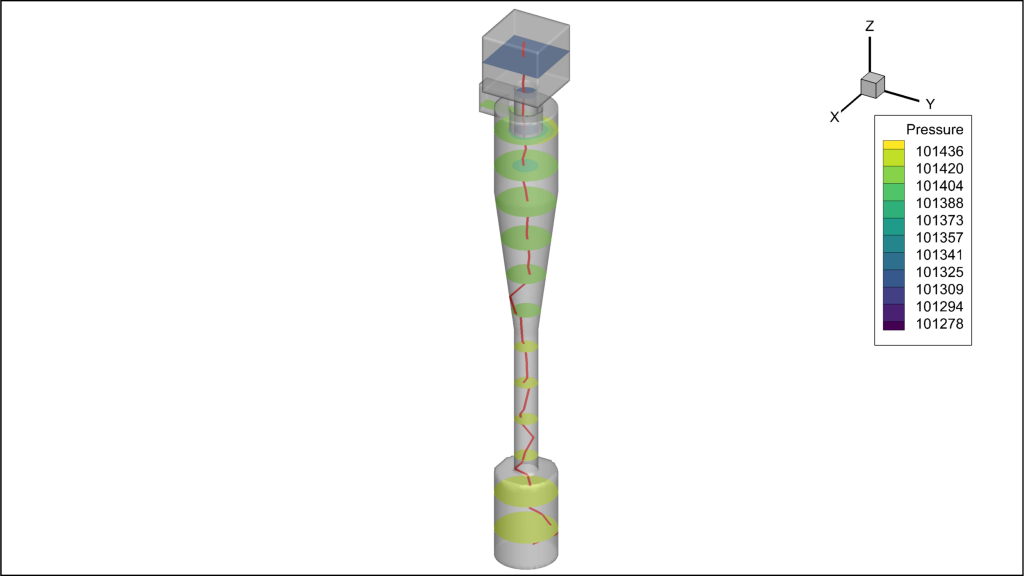

In [5]:
tp.active_frame().plot().fieldmaps().surfaces.surfaces_to_plot = SurfacesToPlot.BoundaryFaces
plot = tp.active_frame().plot(PlotType.Cartesian3D)

plot.fieldmap(final_zone).show=True
plot.fieldmap(final_zone).mesh.color=Color.Red
plot.fieldmap(final_zone).mesh.line_thickness=0.4

# We know that the first fieldmap is the Fluid
plot.fieldmap(0).show=True
plot.fieldmap(0).mesh.show=False

plot.show_mesh=True

plot.use_translucency=True
plot.slice(0).orientation=SliceSurface.ZPlanes
plot.slice(0).show_primary_slice=False
plot.slice(0).show_start_and_end_slices=True
plot.slice(0).show_intermediate_slices=True
plot.slice(0).num_intermediate_slices=12
plot.contour(0).variable=ds.variable("Pressure")
cont_minmax = ds.zone(0).values("Pressure").minmax()
plot.contour(0).levels.reset_levels(np.linspace(cont_minmax[0], cont_minmax[1], 11))
plot.show_slices=True
tp.extension.ipython.show(width=1024)

## Bonus content
Instead of computing the XYZ cell-center copies you could use "low-level" functions to get the cell-centered reference of the XYZ variables directly.  These "tecutil" functions are part of the C-API and do not have direct equivalents from the PyTecplot API.  Calling the funciton below will trigger the derivation of cell-centered data.

Pros:
* Don't have to perform the extra step of computing cell-centered variables using tp.data.execute_equation()
* Don't have to delete extra variables when done
* Can get cell-centered values for a specific zone/variable combination easily

Cons:
* Calling this for every cell is expensive since you're Locking and asking for a data reference every time.

In [6]:
def get_cc_value(zone, variable, index):
    from tecplot.tecutil import _tecutil
    _tecutil.handle.tecUtilParentLockStart(False)
    ref = _tecutil.DataValueGetReadableCCRef(zone.index+1,variable.index+1)
    value = _tecutil.DataValueGetByRef(ref, index+1)
    _tecutil.handle.tecUtilParentLockFinish()
    return value

cell_number = 42
val = get_cc_value(ds.zone(0), ds.variable("X"), cell_number)
print(val)

-0.014658750034868717
